### Quantification table for PAR-2 and RING mutant alleles

- Compiling quantification data into a table
- Quantification data generated using _Run/par2_nebd_quantify.ipynb_

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties

from src import bounded_mean_1d, nb_setup

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg201", "nwg240", "nwg246", "nwg338", "nwg369"]
df = df[df.Line.isin(lines) & (df.RNAi == "wt")]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Perform summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    mem_frac = mem_tot / ((cyt / 0.174) + mem_tot)
    ratio_post = mem_post / cyt
    dosage = cyt + (mem_tot * 0.174)
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
            "Mem frac": mem_frac,
            "Dosage": dosage,
        }
    )


df_summary = (
    df_quantification.groupby("EmbryoID").apply(calculate_summary).reset_index()
)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add uniform vs polarised column
unipol_dict = {
    line: "Pol" if line in ["lp637", "nwg240", "nwg338"] else "Uni" for line in lines
}
df["UniPol"] = df["Line"].map(unipol_dict)

# Add genotype column
genotype_dict = {
    line: "WT"
    if line in ["lp637", "nwg201"]
    else "C56S"
    if line in ["nwg240", "nwg246"]
    else "L109R"
    for line in lines
}
df["Genotype"] = df["Line"].map(genotype_dict)

# Normalise
norm = df[df.Line == "lp637"].Cyt.mean()
for col in ["Cyt", "Mem_tot", "Mem_ant", "Mem_post", "Dosage"]:
    df[col] /= norm

In [3]:
df1 = df[df.UniPol == "Pol"]
df2 = df[df.UniPol == "Uni"]

In [4]:
def create_table(df):
    means = df.groupby("Genotype")[["Cyt", "Mem_post", "Ratio post", "Mem frac"]].mean()
    means = means.rename(
        columns={
            "Cyt": "Cyt_mean",
            "Mem_post": "Mem_mean",
            "Ratio post": "Ratio_mean",
            "Mem frac": "Memfrac_mean",
        }
    )
    stds = df.groupby("Genotype")[["Cyt", "Mem_post", "Ratio post", "Mem frac"]].std()
    stds = stds.rename(
        columns={
            "Cyt": "Cyt_std",
            "Mem_post": "Mem_std",
            "Ratio post": "Ratio_std",
            "Mem frac": "Memfrac_std",
        }
    )
    a = pd.concat([means, stds], axis=1)

    c1 = a.apply(lambda x: f'{x["Cyt_mean"]:.2f} ± {x["Cyt_std"]:.2f}', axis=1)
    c2 = a.apply(lambda x: f'{x["Mem_mean"]:.2f} ± {x["Mem_std"]:.2f}', axis=1)
    c3 = a.apply(lambda x: f'{x["Ratio_mean"]:.2f} ± {x["Ratio_std"]:.2f}', axis=1)
    c4 = a.apply(lambda x: f'{x["Memfrac_mean"]:.2f} ± {x["Memfrac_std"]:.2f}', axis=1)

    RESULTS = pd.DataFrame(
        {
            "Normalised cytoplasmic\nconcentration (μm⁻³)": c1,
            "Normalised membrane\nconcentration (μm⁻²)": c2,
            "M:C ratio (μm)": c3,
            "Fraction at\nmembrane": c4,
        }
    )
    RESULTS = RESULTS.reindex(["WT", "C56S", "L109R"])
    RESULTS.insert(loc=0, column="Genotype", value=RESULTS.index)
    return RESULTS


def plot_table(results):
    fig, ax = plt.subplots()

    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])

    widths = np.array([0.1, 0.22, 0.22, 0.15, 0.22])
    tab = ax.table(
        cellText=cell_text,
        colLabels=results.columns,
        loc="center",
        colWidths=widths,
        cellLoc="left",
        colLoc="left",
    )
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0, len(results.columns)):
        cellDict[(0, i)].set_height(0.1)
        for j in range(1, len(cell_text) + 1):
            cellDict[(j, i)].set_height(0.05)
    ax.axis("off")
    fig.set_size_inches(9, 5)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


#     fig.tight_layout()

### Individual tables

In [5]:
# RESULTS1 = create_table(df1)
# plot_table(RESULTS1)

In [6]:
# RESULTS2 = create_table(df2)
# plot_table(RESULTS2)

### Full table

In [7]:
def create_table2(df):
    means = df.groupby("Genotype")[
        ["Cyt", "Mem_post", "Ratio post", "Mem frac", "Dosage"]
    ].mean()
    means = means.rename(
        columns={
            "Cyt": "Cyt_mean",
            "Mem_post": "Mem_mean",
            "Ratio post": "Ratio_mean",
            "Mem frac": "Memfrac_mean",
            "Dosage": "Dosage_mean",
        }
    )
    stds = df.groupby("Genotype")[
        ["Cyt", "Mem_post", "Ratio post", "Mem frac", "Dosage"]
    ].std()
    stds = stds.rename(
        columns={
            "Cyt": "Cyt_std",
            "Mem_post": "Mem_std",
            "Ratio post": "Ratio_std",
            "Mem frac": "Memfrac_std",
            "Dosage": "Dosage_std",
        }
    )
    a = pd.concat([means, stds], axis=1)

    c1 = a.apply(lambda x: f'{x["Cyt_mean"]:.2f} ± {x["Cyt_std"]:.2f}', axis=1)
    c2 = a.apply(lambda x: f'{x["Mem_mean"]:.2f} ± {x["Mem_std"]:.2f}', axis=1)
    c3 = a.apply(lambda x: f'{x["Ratio_mean"]:.2f} ± {x["Ratio_std"]:.2f}', axis=1)
    c4 = a.apply(lambda x: f'{x["Memfrac_mean"]:.2f} ± {x["Memfrac_std"]:.2f}', axis=1)
    c5 = a.apply(lambda x: f'{x["Dosage_mean"]:.2f} ± {x["Dosage_std"]:.2f}', axis=1)

    RESULTS = pd.DataFrame(
        {
            "Normalised cytoplasmic\nconcentration (μm⁻³)": c1,
            "Normalised posterior membrane\nconcentration (μm⁻²)": c2,
            "Posterior M:C ratio (μm)": c3,
            "Fraction at\nmembrane": c4,
            "Total expression\n(μm⁻³)": c5,
        }
    )
    RESULTS = RESULTS.reindex(["WT", "C56S", "L109R"])
    RESULTS.insert(loc=0, column="Genotype", value=RESULTS.index)
    return RESULTS

In [8]:
RESULTS1b = create_table2(df1)
RESULTS2b = create_table2(df2)
RESULTS1b["Genotype"] = ["PAR-2(WT)", "PAR-2(C56S)", "PAR-2(L109R)"]
RESULTS2b["Genotype"] = [
    "PAR-2(WT); par-3(it71)",
    "PAR-2(C56S); par-3(it71)",
    "PAR-2(L109R); par-3(it71)",
]
RESULTS_FULLb = pd.concat([RESULTS1b, RESULTS2b], axis=0)

In [9]:
def plot_table2(results):
    fig, ax = plt.subplots()
    fontsize = 7
    cell_text = []
    for row in range(len(results)):
        cell_text.append(results.iloc[row])

    widths = np.array([0.2, 0.2, 0.28, 0.2, 0.13, 0.15])
    tab = ax.table(
        cellText=cell_text,
        colLabels=results.columns,
        loc="center",
        colWidths=widths / sum(widths),
        cellLoc="left",
        colLoc="left",
    )
    tab.auto_set_font_size(False)
    cellDict = tab.get_celld()
    for i in range(0, len(results.columns)):
        cellDict[(0, i)].set_height(0.2)
        cellDict[(0, i)].set_text_props(fontproperties=FontProperties(weight="bold"))
        for j in range(1, len(cell_text) + 1):
            cellDict[(j, i)].set_height(0.1)
    tab.set_fontsize(fontsize)
    ax.axis("off")
    fig.set_size_inches(9, 2)
    fig.subplots_adjust(left=0.01, right=0.98, bottom=0, top=1)
    return fig

/usr/local/lib/python3.11/site-packages/matplotlib/table.py:809: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=cellText[row][col],
/tmp/ipykernel_1082/1726591138.py:2: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.savefig("Figs/results_table.png", dpi=600, transparent=True)


/tmp/ipykernel_1082/1726591138.py:3: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.savefig("Figs/results_table.pdf", transparent=True)


/usr/local/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  func(*args, **kwargs)


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


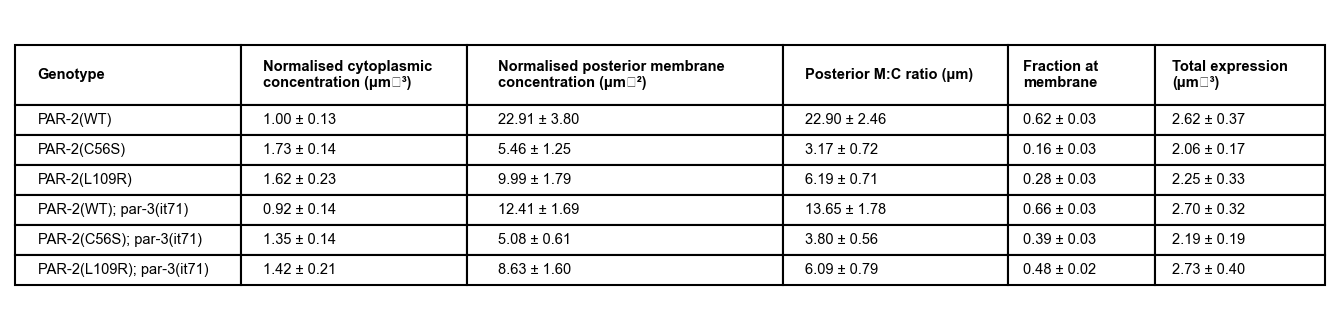

In [10]:
fig = plot_table2(RESULTS_FULLb)
fig.savefig("Figs/results_table.png", dpi=600, transparent=True)
fig.savefig("Figs/results_table.pdf", transparent=True)